# 1. Historical Spotify Data Collection (Kworb)

-----------

**Source:** [Kworb.net](https://kworb.net/spotify/) - Spotify streaming tracking platform

**Method:** Web scraping of individual song pages, collecting daily historical data since 01/01/2017.

**Dataset Columns:**
- `date` - Record date (YYYY-MM-DD)
- `track` - Song name
- `artist` - Artist name
- `streams` - Number of global streams on the day

**Kworb Restriction:** Data is only recorded when the song is in Spotify's **Top 200 Global**.

**Impact:** Christmas songs show data gaps outside the holiday season (January to October), when they generally fall out of the Top 200. Records are more complete and continuous during November and December, the peak listening period for these songs.

In [1]:
pip install pandas requests beautifulsoup4 lxml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import requests #HTTP requests, downloads HTML content from Kworb.net
from bs4 import BeautifulSoup #extract information from HTML
import re #extract values from unstructured HTML
from datetime import datetime #handle dates
import time
import os

#Dictionary with songs to be collected
#key being the song name, where each contains the artist and the URL to find it on Kworb
SONGS_ARTISTS = {
    "All I Want for Christmas Is You": {
        "artist": "Mariah Carey",
        "url": "https://kworb.net/spotify/track/0bYg9bo50gSsH3LtXe2SQn.html"
    },
    "Last Christmas": {
        "artist": "Wham!",
        "url": "https://kworb.net/spotify/track/2FRnf9qhLbvw8fu4IBXx78.html"
    },
    "Santa Tell Me": {
        "artist": "Ariana Grande",
        "url": "https://kworb.net/spotify/track/0lizgQ7Qw35od7CYaoMBZb.html"
    },
    "Jingle Bell Rock": {
        "artist": "Bobby Helms",
        "url": "https://kworb.net/spotify/track/7vQbuQcyTflfCIOu3Uzzya.html"
    },
    "Rockin' Around the Christmas Tree": {
        "artist": "Brenda Lee",
        "url": "https://kworb.net/spotify/track/2EjXfH91m7f8HiJN1yQg97.html"
    },
    "It's Beginning to Look a Lot Like Christmas": {
        "artist": "Michael Bublé",
        "url": "https://kworb.net/spotify/track/0lLdorYw7lVrJydTINhWdI.html"
    },
    "Feliz Navidad": {
        "artist": "José Feliciano",
        "url": "https://kworb.net/spotify/track/3qCeq0rWK67SoBDgFd2sId.html"
    }
}
MIN_DATE = pd.Timestamp('2017-01-01') #minimum analysis date

In [3]:
def collect_song_data(track_name, artist, url):#accesses the Kworb page, extracts the daily streams history table and returns a list with organized data.

    headers = {
        'User-Agent': 'Mozilla/5.0' #avoid blocking, using real browser
    }

    try:
        response = requests.get(url, headers=headers, timeout=15) #Downloads the Kworb page through the URL defined above and prevents the program from waiting forever
        response.raise_for_status() #error warning if download returns 404
    except Exception as e:
        print(f"Error accessing {url}: {e}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser') #transforms the HTML into BeautifulSoup object
    table = soup.find('table') #searches for the first table tag in the HTML and returns the entire table block


    if not table:
        print(f"Table not found for: {track_name}")
        return []

    data = [] #where outputs will be stored (data, track, artists and streams)
    rows = table.find_all('tr')[1:] #gets all table rows, except the header

    for row in rows: #for all rows
        cells = row.find_all('td') #gets the cells from each table row and puts them in a list called cells
        if len(cells) < 2: #Valid row needs to have at least 2 columns: date + streams.
            continue

        date_str = cells[0].text.strip() #column 0 being the dates.
        if date_str.lower() in ['total', 'peak', '']:  #transforms text to lowercase to standardize
        #list of cases we don't want to process (total and peak)
            continue
        date = None
        for fmt in ('%Y/%m/%d', '%d/%m/%Y'): #Kworb changes the date format depending on the time. That's why the loop is important to try both ways
            try:
                date = pd.to_datetime(date_str, format=fmt) #dataframe with dates
                break
            except:
                pass

        if date is None or date < MIN_DATE: #if it couldn't convert or is less than the 2017 date, skip this data
            continue

        global_str = cells[1].text.strip()#gets streams column (number of times listened) -> GLOBAL, other columns are from other countries.

        #Extracts the number between parentheses, when it exists, example -> (456,789) extracts these parentheses
        if '(' in global_str:
            match = re.search(r'\(([0-9,]+)\)', global_str) #extracts only the number.
            if not match:
                continue
            streams_str = match.group(1)
        else:
            streams_str = global_str
        streams_str = streams_str.replace(',', '')  #Removes commas.
        if not streams_str.isdigit(): #Checks if it's only numbers.
            continue

        streams = int(streams_str)#Converts to integer.

        data.append({ #Each item will be a future table row.
            'date': date,
            'track': track_name,
            'artist': artist,
            'streams': streams
        })

    return data #returns the data of date, track_name, artist and streams

- Kworb Data Extraction Process Flow:

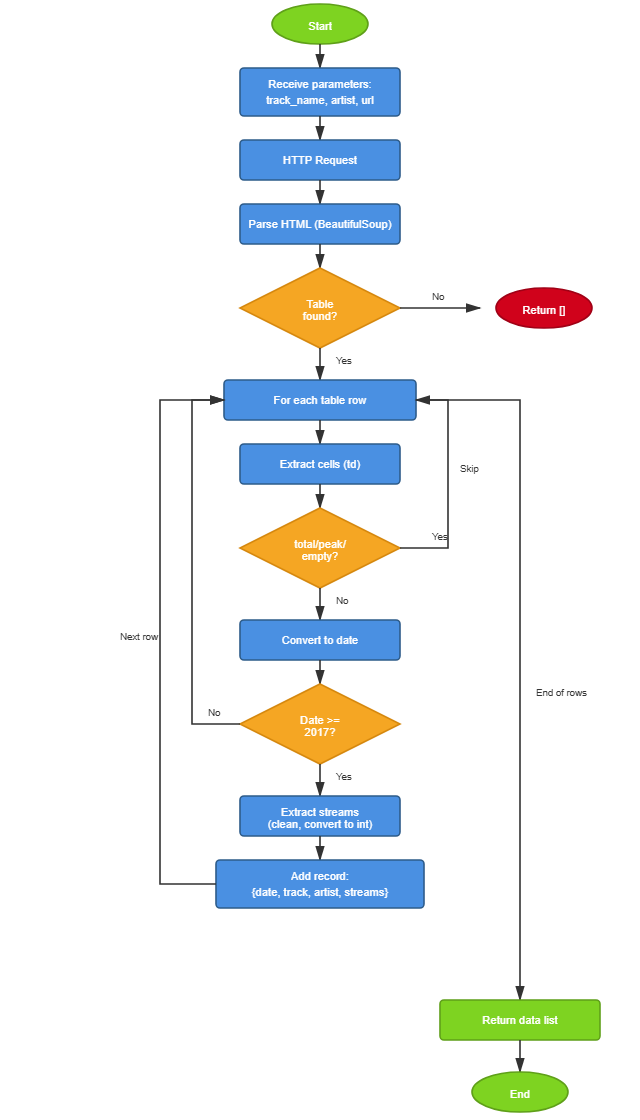

In [4]:
all_data = []

for idx, (track_name, info) in enumerate(SONGS_ARTISTS.items(), 1): #iterates through all songs in the SONGS_ARTISTS dictionary
    #makes idx start at 1 instead of 0, idx = 1, track_name = "All I Want For Christmas Is You"
    print(f"{idx}/{len(SONGS_ARTISTS)} - Collecting: {track_name}") #shows the song index/total songs and displays the song name

    data = collect_song_data( #applies this function defined above from the dictionary parameters of each song
        #passes the song name, artist name and URL to collect the data
        track_name=track_name,
        artist=info['artist'],
        url=info['url']
    )
    #data returns -> date, song name, artist name and streams
    print(f"Records collected: {len(data)}")# sees the amount of data collected (number of points found) for each song
    all_data.extend(data) # adds all data to the all_data vector to store.

    if idx < len(SONGS_ARTISTS):
        time.sleep(2) #waits 2 seconds between analyzing each song to avoid server overload.

print(f"\nFinal total of records collected: {len(all_data)}")

1/7 - Collecting: All I Want for Christmas Is You
Records collected: 69
2/7 - Collecting: Last Christmas
Records collected: 63
3/7 - Collecting: Santa Tell Me
Records collected: 53
4/7 - Collecting: Jingle Bell Rock
Records collected: 49
5/7 - Collecting: Rockin' Around the Christmas Tree
Records collected: 54
6/7 - Collecting: It's Beginning to Look a Lot Like Christmas
Records collected: 49
7/7 - Collecting: Feliz Navidad
Records collected: 39

Final total of records collected: 376


In [5]:
if len(all_data) == 0: #if no data is found
    print("No data collected.")
else:
    df = pd.DataFrame(all_data) #dataframe with all data acquired in the function above
    df = df.sort_values(['date', 'track']).reset_index(drop=True) #sorts by date (primary) and track name alphabetically (secondary), then resets index
    df['day_of_week'] = df['date'].dt.day_name() #gets the day of the week for each date
    df['week_of_year'] = df['date'].dt.isocalendar().week #gets the week number of the year for each date

    display(df.head()) #beginning
    display(df.tail()) #end

,date,track,artist,streams,day_of_week,week_of_year
0,2017-11-16,All I Want for Christmas Is You,Mariah Carey,3821572,Thursday,46
1,2017-11-23,All I Want for Christmas Is You,Mariah Carey,6130250,Thursday,47
2,2017-11-23,Last Christmas,Wham!,4040197,Thursday,47
3,2017-11-30,All I Want for Christmas Is You,Mariah Carey,11641888,Thursday,48
4,2017-11-30,It's Beginning to Look a Lot Like Christmas,Michael Bublé,4577042,Thursday,48


,date,track,artist,streams,day_of_week,week_of_year
371,2025-11-27,It's Beginning to Look a Lot Like Christmas,Michael Bublé,13273043,Thursday,48
372,2025-11-27,Jingle Bell Rock,Bobby Helms,17216703,Thursday,48
373,2025-11-27,Last Christmas,Wham!,23091279,Thursday,48
374,2025-11-27,Rockin' Around the Christmas Tree,Brenda Lee,19251893,Thursday,48
375,2025-11-27,Santa Tell Me,Ariana Grande,16838299,Thursday,48


In [6]:
import os
import pandas as pd

# Gets the current notebook folder
project_folder = os.getcwd()
filename = "spotify_christmas_streams_kworb_2017_2025.csv" #csv name
filepath = os.path.join(project_folder, filename) #creates the file path by joining the project folder with the filename
# Save CSV
df.to_csv(filepath, index=False) #saves the treated dataframe defined above to csv

- For Colab:

In [7]:
#from google.colab import files
#files.download("christmas_songs_database_2017_2025_extended.csv")